# PROJECT 3
**MOD510: Mandatory project 3**  
**Deadline: 11. Novenber 2024 (23:59)**

Authors:  
*Dea Lana Asri*  
*Sander Øydal Sterri*  
*Urszula Maria Starowicz*  

**ABSTRACT**

This study models tracer dynamics in an aorta-like system using ODE solvers (Euler, RK2, RK4) and a Continuous-Stirred Tank Reactor (CSTR) approach. Initial tests compared solver accuracy, highlighting trade-offs in computational efficiency. The CSTR model was then fitted to healthy aorta data by adjusting parameters like $\tau=2.32 (s)$ and compartment count $n=50$ resulting in a model fit with R-squared values above 0.90 for every concentration injection function tried. Finally, we adapted the CSTR model to simulate an aneurysmal aorta by modifying the parameters to $\tau=2.48 (s)$ compartment count $n=30$ resulting in a reduced fit across all injection protocol functions. These findings suggest that while the CSTR model provides an efficient approach for aortic diagnostics, limitations arise under complex flow conditions. This underscores the need for additional model refinement when diagnosing structural abnormalities like aneurysms.  
In this extended study, we adapted the CSTR model to incorporate diffusive exchange, enhancing its accuracy in simulating tracer dynamics in aneurysmal aortas. This adaptation improved the model's fit to aneurysm data, increasing the R-squared values from 0.9947 to 0.9951 for the one-second rectangular pulse injection function. These results suggest that the CSTR model can be further refined to enhance its diagnostic capabilities in complex flow conditions, such as in aneurysmal aortas.



# Introduction
In this project, we aim to explore the effectiveness of simplified models for simulating tracer dynamics in complex biological systems, specifically within an aortic arch. Given that full-scale computational fluid dynamics (CFD) simulations of fluid flow are computationally expensive and require detailed geometric data, simplified approaches, such as Continuous Stirred Tank Reactor (CSTR) models, are often used as alternatives. 

In the first task, we developed an ODE solver to approximate the tracer concentration in an aorta-like system represented by multiple tanks in series. Through numerical experiments using the Euler, Runge-Kutta second-order (RK2), and fourth-order (RK4) methods, we investigate how well these methods simulate tracer dynamics relative to analytical solutions while analyzing the error scaling of each approach. This comparison provides insight into the balance between model accuracy and computational efficiency in reservoir engineering and medical diagnostics. Through this, we have learned that simplified models like the CSTR with a series of tanks can effectively approximate tracer dynamics in large, complex systems, though they inherently lack the granularity of a full CFD simulation. The exercise in developing and applying ODE solvers underscored the importance of choosing an appropriate numerical method based on accuracy requirements and computational constraints, with higher-order methods like RK4 achieving significantly lower error scaling. Additionally, the hands-on experience with error scaling demonstrated how different methods respond to step-size adjustments, reinforcing the theoretical understanding of numerical accuracy in solving ODEs. This project illustrates the balance between model tractability and fidelity and how numerical methods can be tailored to fit specific engineering applications.   

In Exercise 2, we aim to validate a Continuous-Stirred Tank Reactor (CSTR) model by fitting it to Computational Fluid Dynamics (CFD) simulations of a tracer in a healthy aorta. Since experimental data is unavailable, simulated concentration profiles are used. Our primary question is whether the tracer signal alone can reveal details about the aorta arch, such as identifying an aneurysm. By examining injection protocols (rectangular pulse, ramp pulse, and biphasic pulse) and adjusting key parameters like flow rate 𝑞, we use mass conservation principles to connect simulated and modeled results, which could have real-world applications in medical diagnostics.  
   
Exercise 3 focuses on adapting the Continuous-Stirred Tank Reactor (CSTR) model to simulate an aorta with an aneurysm, using concentration profile data. This exercise builds on the previous task by requiring recalibration of the model's total volume $V_{tot}$  and compartment count $n$ to reflect the altered flow dynamics associated with an aneurysm. This approach aims to test whether the CSTR model can capture the impact of structural abnormalities in the aorta based only on tracer signal data.


In [1]:
# IMPORTS
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.integrate import simpson 

**Exercise 1: Write your own ODE solver**  
Part 1

In [2]:
class ODESolver:
    def __init__(self, f, y0, t0, tf, method='RK4', dt=0.01):
        """
        Initialize the ODE solver.
        
        Parameters:
        - f: function defining the system of ODEs (dy/dt = f(y, t))
        - y0: initial condition (array)
        - t0: initial time
        - tf: final time
        - method: method to use ('Euler', 'RK2', 'RK4')
        - dt: time step size
        """
        self.f = f
        self.y0 = np.array(y0, dtype=float)
        self.t0 = t0
        self.tf = tf
        self.method = method
        self.dt = dt

    def euler(self):
        """ Euler's method for ODEs. """
        t = self.t0
        y = self.y0
        results = [(t, y.copy())]
        
        while t < self.tf:
            y += self.dt * self.f(y, t)
            t += self.dt
            results.append((t, y.copy()))
        
        return results

    def rk2(self):
        """ Runge-Kutta second order method for ODEs. """
        t = self.t0
        y = self.y0
        results = [(t, y.copy())]
        
        while t < self.tf:
            k1 = self.f(y, t)
            k2 = self.f(y + 0.5 * k1 * self.dt, t + 0.5 * self.dt)
            y += self.dt * (0.5 * k1 + 0.5 * k2)
            t += self.dt
            results.append((t, y.copy()))
        
        return results

    def rk4(self):
        """ Runge-Kutta fourth order method for ODEs. """
        t = self.t0
        y = self.y0
        results = [(t, y.copy())]
        
        while t < self.tf:
            k1 = self.f(y, t)
            k2 = self.f(y + 0.5 * self.dt * k1, t + 0.5 * self.dt)
            k3 = self.f(y + 0.5 * self.dt * k2, t + 0.5 * self.dt)
            k4 = self.f(y + self.dt * k3, t + self.dt)
            y += (self.dt / 6) * (k1 + 2 * k2 + 2 * k3 + k4)
            t += self.dt
            results.append((t, y.copy()))
        
        return results

    def solve(self):
        """ Choose the method and solve the ODE system. """
        if self.method == 'Euler':
            return self.euler()
        elif self.method == 'RK2':
            return self.rk2()
        elif self.method == 'RK4':
            return self.rk4()
        else:
            raise ValueError("Unknown method specified. Choose 'Euler', 'RK2', or 'RK4'.")


The ODESolver class takes the function f that defines the system of ODEs, the initial conditions y0, the starting and ending times (t0 and tf), the method to use, and the time step size dt.  
  
*Euler's Method*: Updates the state using the derivative evaluated at the current state.  
*RK2*: Uses the average of two derivative evaluations to update the state.  
*RK4*: Provides a more accurate update by using four derivative evaluations.  

Part 2  
  
For actual modeling scenarios, $\tau$ would be determined by the physical properties of the system, like flow rate and volume, as well as the desired scale of temporal behavior. However, for testing purposes, using $\tau$=2 offers a balanced combination of clarity, simplicity, and reliability.   
  
The right-hand side function which needed input parameters for the ODESolver class was defined as a rhs class that takes y, t, n, and $\tau$ as input parameters. In this particular case, the default value of n was set to 3, and $\tau$ was set to 2. The function returns the derivative of y at time t defining how the concentration changes over time.

Method: Euler, n: 1, Error: 0.4804168224999866
Method: RK2, n: 1, Error: 0.24008185252902903
Method: RK4, n: 1, Error: 1.00265114266751e-09


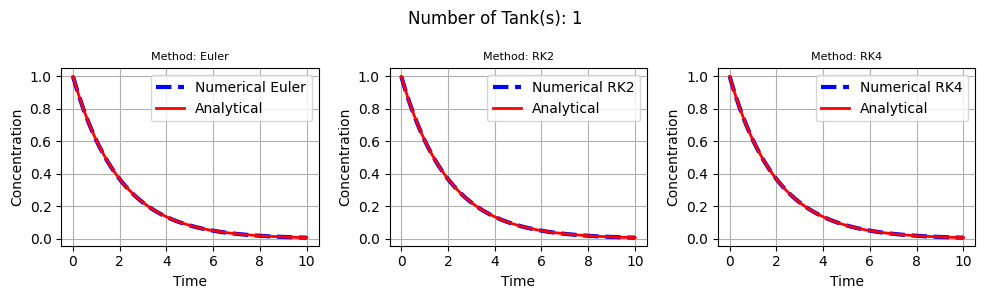

Method: Euler, n: 2, Error: 0.5415553581716158
Method: RK2, n: 2, Error: 0.27015885971024395
Method: RK4, n: 2, Error: 2.604098354633917e-08


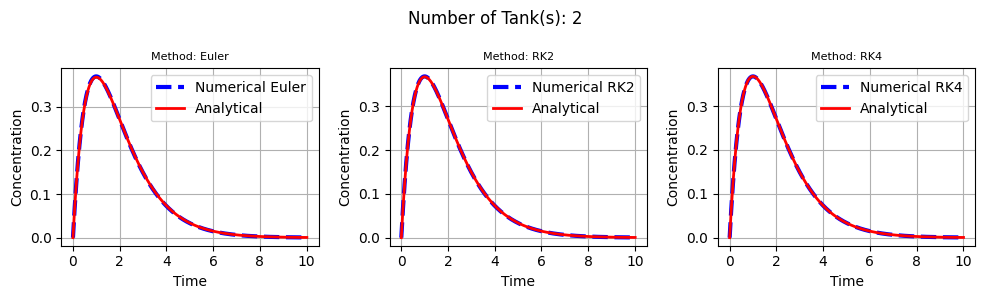

Method: Euler, n: 3, Error: 0.5061677678843335
Method: RK2, n: 3, Error: 0.2521066679692257
Method: RK4, n: 3, Error: 1.0513706495688448e-07


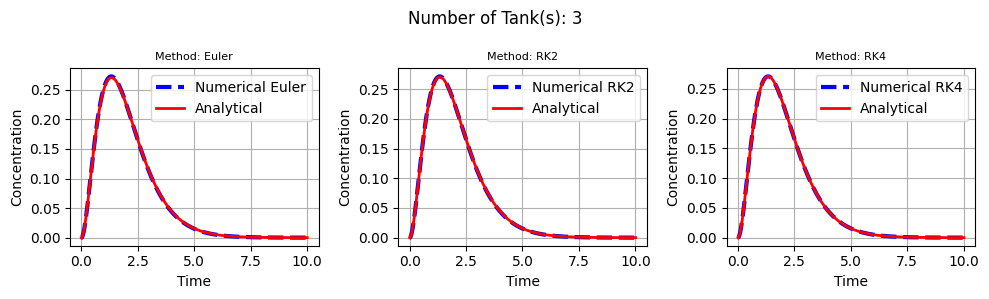

In [18]:
def rhs(y, t, n=3, tau=2):
    """
    Right-hand side function
    Param:
    y: Concentration C0, C1, ..., Cn-1 (array)
    t: time
    n: number of tanks in series (default is 3)
    tau: time constant (default is 2)
    Return:
    dydt: array of dy/dt values for each tank
    """
    dydt = np.zeros(n)
    dydt[0] = -n / tau * y[0] # because Cin = 0
    for i in range(1, n):
        dydt[i] = n / tau * (y[i - 1] - y[i])
    return dydt

def analytical(t, n=3, tau=2):
    """
    Analytical solution of the ODE
    """
    if n == 1:
        result = np.exp(-t / tau)
    elif n == 2:
        result = (2 * t / tau) * np.exp(-2 * t / tau)
    elif n == 3:
        result = (9 * t**2 / (2 * tau**2)) * np.exp(-3 * t / tau)
    else:
        raise ValueError("Analytical solution is only available for n = 1, 2, or 3")
    return result
    
# Time parameters
t0 = 0.0
tf = 10.0
dt = 0.01
times = np.arange(t0, tf, dt)

# Initial conditions
y0 = np.array([1.0, 0.0, 0.0])

#Plotting for n=1, 2, 3
n_values = [1, 2, 3]
for n in n_values:
    fig, axes = plt.subplots(1, 3, figsize=(10, 3))
    fig.suptitle(f'Number of Tank(s): {n}')

    # Plot the results for 'Euler', 'RK2', 'RK4' methods
    methods = ['Euler', 'RK2', 'RK4']
    for idx, method in enumerate (methods):
        solver = ODESolver(lambda y, t: rhs(y, t, n=n), y0[:n], t0, tf, method, dt)
        time, y = zip(*solver.solve())
        y = np.array(y)
        time = np.array(time)

        #calculate the error
        error = np.abs(y[:, n-1] - analytical(time, n=n))
        print(f'Method: {method}, n: {n}, Error: {np.sum(error)}')

        # Plot the results
        plt.subplot(1, 3, idx+1)
        plt.plot(time, y[:, n-1], label=f'Numerical {method}', linestyle='dashed', color='b', linewidth=3)
        plt.plot(time, analytical(time, n=n), label='Analytical', linestyle='solid', color='r', linewidth=2)
        plt.title(f'Method: {method}', fontsize=8)
        plt.xlabel('Time')
        plt.ylabel('Concentration')
        plt.legend()
        plt.grid()
    plt.tight_layout()
    plt.show()

Although visual inspection of the plots suggests that all methods can approximate the analytical solution, the error values reveal that, for each n value, RK4 has the lowest error, followed by RK2, with Euler having the highest. This aligns with the theory that higher-order methods exhibit lower error scaling [(Hiorth, 2021)](#hiorth)    

Part 3

Pick n=1, 2, or 3. Plot the numerical error at t = 1, for the last tank, and for dt values in the range 0.1,...0.001. (You may try lower values if you have a very fast solver)

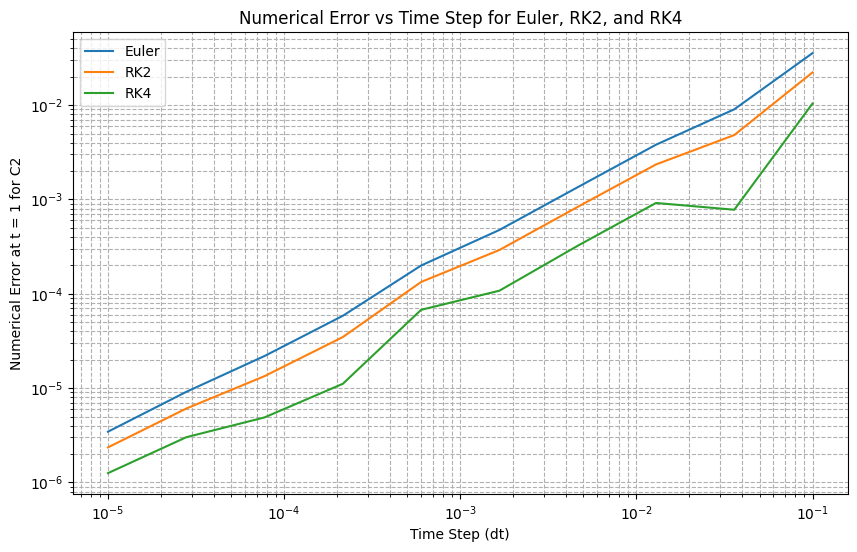

In [4]:
# Choosing n value
n = 3

# List of time steps to test
dt_values = np.logspace(-5, -1, num=10)  # 0.00001, ..., 0.1
tau = 2
t_target = 1
y0 = [1, 0, 0]  # C0(0) = 1, C1(0) = C2(0) = 0


# Initialize error storage for each method
errors = np.zeros((3, len(dt_values)))


# Loop over each dt value
for idx1, dt in enumerate (dt_values):
    # Create an instance of the ODE solver for each method
    methods = ['Euler', 'RK2', 'RK4']
    for idx2, method in enumerate (methods):
        solver = ODESolver(lambda y, t: rhs(y, t, n=n, tau=tau), y0[:n], 0, t_target, method, dt=dt)
        time, y = zip(*solver.solve())
        y = np.array(y)
        time = np.array(time)
        # Extract the output concentration at the t approximately 1
        C_out = y[-1, -1]

        # Calculate analytical solution
        C_analytical = analytical(t_target, n=n, tau=tau)

        # Compute the error
        error = np.abs(C_out - C_analytical)

        # Store the error
        errors[idx2, idx1] = error


plt.figure(figsize=(10, 6))
for idx, method in enumerate(methods):
    plt.loglog(dt_values, errors[idx, :], label=method)
plt.xlabel("Time Step (dt)")
plt.ylabel(f'Numerical Error at t = {t_target} for C{n-1}')
plt.title("Numerical Error vs Time Step for Euler, RK2, and RK4")
plt.legend()
plt.grid(True, which="both", ls="--")
plt.show()

Does the numerical error scale as expected for Euler, RK2, and RK4?

### Euler Method

Euler's method is a first-order numerical technique for solving ordinary differential equations (ODEs). It estimates the next point in the solution based on the rate of change at the current point. It operates by taking the derivative at the current point to predict the next value. However, Forward Euler's method is known to be unconditionally unstable for undamped oscillating systems and generally is not recommended for hyperbolic differential equations due to its diffusive nature, and it exhibits poor convergence behavior as the grid is refined.

### Runge-Kutta Methods  

Runge-Kutta (RK) methods comprise a family of numerical schemes that are derived systematically. The forward Euler method is the simplest form of an RK method, classified as a one-stage, first-order scheme. Higher-order RK methods are multi-stage, involving multiple slope calculations at various points between the current and the next discrete time values. The next value of the dependent variable is obtained by computing a weighted average of these slopes based on a Taylor series approximation. The weights in this average are derived from solving non-linear algebraic equations that cancel out the error terms in the Taylor series expansion.  

Overall, a higher-order numerical algorithm like the RK4 method reduces numerical error in the approximation of the derivative, which produces a more accurate estimate, but its computational cost is higher [(Wu, 2012)](#wu)

### Comparison of Errors

In general, the error associated with Euler's method tends to be greater than that of higher-order RK methods due to the lower truncation error present in these more sophisticated approaches. Many introductory texts on numerical methods suggest that higher-order methods typically produce lower errors than lower-order methods. While this is often true, it is not universally applicable, as the performance depends on factors such as the mesh size, initial conditions, and the specific differential equations being solved.  

The errors shown for each method align with theoretical expectations: Euler's method has the highest error among the three, followed by RK2, while RK4 has the lowest error. This matches the expected accuracy order of the methods, where RK4 is the most accurate and Euler is the least accurate [(Hiorth, 2021)](#ahiorth). The plot also reveals that the error decreases as the step size decreases, which is consistent with the expected behavior of numerical methods.

However, from the plot above, we observe that the error for the RK4 method becomes unstable as the step size (dt) increases. This instability is consistent with the known limitations of the RK4 method, which can struggle with numerical stability when the step size is too large. Larger step sizes can lead to inaccuracies in approximating the solution, causing numerical divergence or significant deviations from the analytical value.

Moreover, the fluctuations in the RK4 error are also influenced by how the output concentration $C_{out}$ is being computed at t = 1. Since t is not exactly 1 for many of the tested step sizes. This introduces additional error, especially for RK4, which is more sensitive due to its high precision. Small inaccuracies during extraction of the value can have a disproportionate impact when the true error is very small, contributing to the irregular pattern seen in the error plot.

The numerical error for Euler, RK2, and RK4 methods are $\mathcal{O}(\Delta t)$, $\mathcal{O}(\Delta t^2)$, and $\mathcal{O}(\Delta t^4)$, respectively [(Hiorth, 2021)](#hiorth). However, the plot above does not display the expected error scaling for these methods. We suspect this discrepancy may be due to factors such as the accumulation of truncation and round-off errors, as well as the possibility that the concentration was not extracted at precisely t=1.



**Exercise 2: Fit CSTR model to CFD model: Healthy aorta**  
Part 1

In [5]:
Minj = 83.333  # grams of tracer injected

# Load the concentration data from the CSV file
data = pd.read_csv('data/Healthy_rect_1s.csv')
time = data['Time'].values  # Time in seconds
concentration_data = data['Concentration'].values  # Concentration at the outlet in g/L

# Calculate the time step, assuming it is constant
dt = time[1] - time[0] 

# Integrate C_out over time to get the area under the curve using Simpson's rule
integral_Cout = simpson(concentration_data, dx=dt)

# Calculate flow rate q in L/s
q = Minj / (integral_Cout*1000) 

# Convert q from L/s to L/min
q_L_per_min = q * 60

print(f"The calculated flow rate q is approximately {q_L_per_min:.2f} L/min")

The calculated flow rate q is approximately 5.01 L/min


Part 2  
  
Injection protocols:

In [6]:
# Create a Rectangular Pulse function that can be used to generate the input flow rate
def rectangular(t, threshold):
    """Creates a rectangular pulse of 1.0 for t <= threshold, otherwise 0.0."""
    return 1.0 if t <= threshold else 0.0

def ramp(t, slope=1, max_time=1):
    """Returns ramp value based on slope until max_time, otherwise returns 0.0."""
    return slope * t if t < max_time else 0.0

def biphasic(t, first_phase_time=1, first_phase_value=0.7, second_phase_time_range=[2, 3], second_phase_value=1.0):
    """Returns the value based on a biphasic pattern."""
    if t <= first_phase_time:
        return first_phase_value
    elif second_phase_time_range[0] <= t <= second_phase_time_range[1]:
        return second_phase_value
    else:
        return 0.0

Part 3  
  
To optimalize tau value we used Newton-Raphson alghorithm [(Hiorth)](#ahiorth)

In [7]:
# Define the ODE system for n tanks in series
def cstr_model(t, C, n, tau, C_inj_function):
    '''CSTR Model
    params:
    t: time (s)
    C: concentration (g/L)
    n: number of tanks
    tau: Volume/flow rate (s)
    C_inj_function: input concentration function
    Return: 
    dCdt: Rate of change of concentration for each tank'''
    dCdt = np.zeros(n)
    C_inj = C_inj_function(t)
    dCdt[0] = (n/tau) * (C_inj - C[0])
    for i in range(1, n):
        dCdt[i] = (n/tau) * (C[i-1] - C[i])
    return dCdt

# Objective function to minimize (SSR)
def objective_function(tau, n, time_data, concentrations_data, C_inj_function):
    C_initial = np.zeros(n)
    C_initial[0] = 1  # Initial concentration in the first tank

    # Solve the ODEs
    sol = solve_ivp(cstr_model, [time_data[0], time_data[-1]], C_initial, args=(n, tau, C_inj_function), t_eval=time)
    
    # Compute simulated effluent concentration
    simulated_concentration = sol.y[-1]  # Last tank concentration

    # Calculate SSR
    ssr = np.sum((simulated_concentration - concentrations_data)**2)
    return ssr

# Function to calculate the derivative of SSR
def calculate_derivative_ssr(tau, n, time_data, concentrations_data, C_inj_function, delta_tau=1e-5):
    ssr_current = objective_function(tau, n, time_data, concentrations_data, C_inj_function)
    ssr_plus = objective_function(tau + delta_tau, n, time_data, concentrations_data, C_inj_function)
    
    derivative_ssr = (ssr_plus - ssr_current) / delta_tau
    return derivative_ssr

def optimize_tau_newton_raphson(n, time_data, concentrations_data, C_inj_function, initial_tau=2.0, tol=1e-7, max_iter=100):
    tau = initial_tau
    
    for i in range(max_iter):
        ssr = objective_function(tau, n, time_data, concentrations_data, C_inj_function)
        derivative_ssr = calculate_derivative_ssr(tau, n, time_data, concentrations_data, C_inj_function)
        
        if abs(derivative_ssr) < 1e-10:
            print(f"Iteration {i}: Derivative is too small; cannot update tau.")
            break
        
        # Update tau using the Newton-Raphson formula
        tau_new = tau - ssr / derivative_ssr

        if abs(tau_new - tau) < tol or abs(ssr) < tol:
            print(f"Converged at iteration {i}")
            break
        tau = tau_new
    return tau

# Function to calculate r squared value to evaluate the model
def r_squared(true_value, pred_value):
    ss_total = np.sum((true_value - np.mean(true_value))**2)
    ss_residual = np.sum((true_value - pred_value)**2)
    r_squared = 1 - (ss_residual / ss_total)
    return r_squared

To determine the optimal value of $\tau$, which represents the time constant of the system, we use the Newton-Raphson optimization method to minimize the Sum of Squared Residuals (SSR) between the experimental concentration data and the simulated concentration values from the model.

Optimal τ: 2.3189 (s)
R² for n=10: 0.6892
R² for n=20: 0.8913
R² for n=30: 0.9527
R² for n=40: 0.9718
R² for n=50: 0.9792
R² for n=100: 0.9562
R² for n=200: 0.9038
R² for n=300: 0.8689


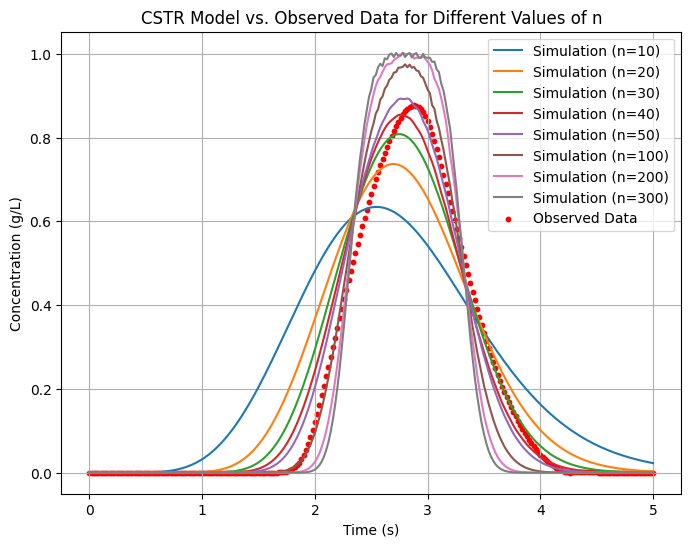

In [8]:
# Load the concentration data from the CSV file
data = pd.read_csv('data/Healthy_rect_1s.csv')
time = data['Time'].values  
concentration_data = data['Concentration'].values  

# Parameters for the CSTR model
q = 0.083  # Volumetric flow rate (L/s)
C_inj_function = lambda t: rectangular(t, 1) # Input concentration function, Rectangular pulse at t=1


# Initial number of tanks
n = 50

# Tune tau
optimal_tau = optimize_tau_newton_raphson(n, time, concentration_data, C_inj_function)
print(f'Optimal τ: {optimal_tau:.4f} (s)')

# Manual tuning for n
n_values = [10, 20, 30, 40, 50, 100, 200, 300]

# Plotting for each value of `n`
plt.figure(figsize=(8, 6))

for n in n_values:
    # Initial conditions for concentration
    C_initial = np.zeros(n)
    C_initial[0] = 1  # Initial concentration in the first tank

    # Solve the ODE system with the given `n`
    sol = solve_ivp(cstr_model, [time[0], time[-1]], C_initial, args=(n, optimal_tau, C_inj_function), t_eval=time)

    # calculate the r squared value
    r_squared_value = r_squared(concentration_data, sol.y[-1])
    print(f'R² for n={n}: {r_squared_value:.4f}')
    
    # Plot the simulation result for the current `n`
    plt.plot(sol.t, sol.y[-1], label=f'Simulation (n={n})')

# Plot the experimental data
plt.scatter(time, concentration_data, label='Observed Data', color='red', s=10)

# Formatting the plot
plt.title('CSTR Model vs. Observed Data for Different Values of n')
plt.xlabel('Time (s)')
plt.ylabel('Concentration (g/L)')
plt.legend()
plt.grid(True)
plt.show()

After determining the optimal $\tau$ value, we try to find the optimal number of tanks (n) that best fits the experimental data accordingly. To save computational time, we use the optimal $\tau$ value obtained in the previous step and vary the number of tanks from 10, 20, 30, 40, 50, 100, and 200.

The result shows that the most optimal $\tau$ is 2.32 (s) with an optimal number of tanks of 50 which gives the highest R-squared value of 0.98.

Part 4

R² for 1s Rectangular Pulse: 0.9924
R² for 2s Rectangular Pulse: 0.9866
R² for 3s Rectangular Pulse: 0.9910
R² for 1s Ramp: 0.9607
R² for Biphasic: 0.9692


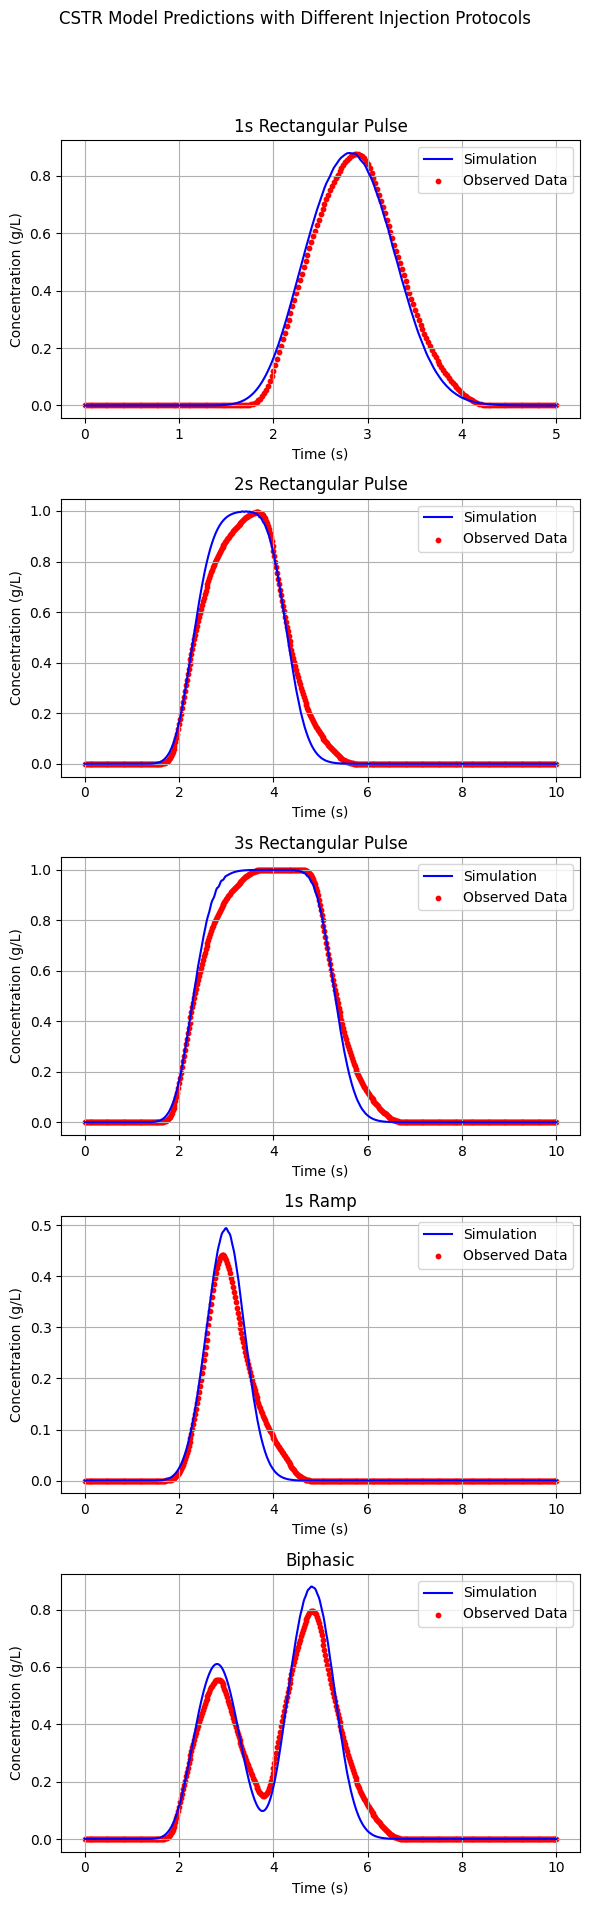

In [9]:
# Parameters
n = 50          # Number of tanks based on optimization on part 3
q = 0.083          # Volumetric flow rate (L/s)
tau = optimal_tau  # Optimal tau from tuning (s)
C_initial = np.zeros(n)   # Initial concentration in each tank

# Define injection protocols and corresponding data files
injection_protocols = {
    "1s Rectangular Pulse": (lambda t: rectangular(t, 1), 'data/Healthy_rect_1s.csv'),
    "2s Rectangular Pulse": (lambda t: rectangular(t, 2), 'data/Healthy_rect_2s.csv'),
    "3s Rectangular Pulse": (lambda t: rectangular(t, 3), 'data/Healthy_rect_3s.csv'),
    "1s Ramp": (lambda t: ramp(t, 1, 1), 'data/Healthy_ramp_1s.csv'),
    "Biphasic": (lambda t: biphasic(t), 'data/Healthy_biphasic.csv')
}

# Set up subplots
num_protocols = len(injection_protocols)
fig, axs = plt.subplots(num_protocols, 1, figsize=(6, 4 * num_protocols))
fig.suptitle('CSTR Model Predictions with Different Injection Protocols')

for ax, (label, (C_inj_func, data_file)) in zip(axs, injection_protocols.items()):
    # Load the specific dataset for the injection protocol
    data = pd.read_csv(data_file)
    time_data = data['Time'].values
    concentration_data = data['Concentration'].values
    
    # Solve the model with the chosen injection protocol
    sol = solve_ivp(cstr_model, [time_data[0], time_data[-1]], C_initial, 
                    args=(n, tau, C_inj_func), t_eval=time_data)
    
    # Calculate the r squared value
    r_squared_value = r_squared(concentration_data, sol.y[-1])
    print(f'R² for {label}: {r_squared_value:.4f}')
    
    # Plot the model prediction and observed data
    ax.plot(sol.t, sol.y[-1], label='Simulation', color='blue')  # Last tank concentration
    ax.scatter(time_data, concentration_data, label='Observed Data', color='red', s=10)
    ax.set_title(f'{label}')
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Concentration (g/L)')
    ax.legend()
    ax.grid()

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


Based on the R² values and visual inspection of the simulation results, it is evident that the model performs reasonably well for rectangular pulse injections. This suggests that the model is well-suited for capturing constant injection concentration.

However, for ramp and biphasic pulse injections, the model's performance is slightly lower might be because the current model struggles to accurately represent these more complex injection profiles. This could be because the current model, which is based on a series of Continuous Stirred Tank Reactors (CSTRs), was initially developed and fitted using data from rectangular pulse injections and lacks the necessary complexity to capture the gradual changes and multiple phases of the ramp and biphasic injections.

However, the model's overall performance is good considering the R-squared values for all injection protocols are above 0.9, indicating a strong correlation between the simulated and experimental data. 

**Exercise 3: Fit CSTR model to CFD model: Aorta with aneurysm**  
Part 1

In [10]:
# Load data from CSV
data_aneurysm = pd.read_csv('data/Aneurysm_rect_1s.csv') 
time_aneurysm = data_aneurysm['Time'].values
concentration_aneurysm = data_aneurysm['Concentration'].values

# Parameters
n = 50  # Initial number of tanks
q = 0.083  # Volumetric flow rate (L/s)
C_inj_function = lambda t: rectangular(t, 1)  # Rectangular pulse at t=1

# Tune tau
optimal_tau_aneurysm = optimize_tau_newton_raphson(n,time_aneurysm, concentration_aneurysm, C_inj_function, initial_tau=2, max_iter=30, tol=1e-5)
print(f'Optimal τ: {optimal_tau_aneurysm:.4f} (s)')



Optimal τ: 2.4837 (s)


Using the Newton-Raphson method, we determined the optimal value of τ for the aneurysm model to be 2.4837, given an initial number of tanks equal to 50, and initial $\tau$ equal to 2. However, this method poses challenges when finding the optimal τ, primarily due to its strong dependence on the initial guess [(Deuflhand, 2011)](#deuflhand). If the initial guess is not close to the true optimal value, the method may fail to converge to an appropriate result. This failure can occur for several reasons: the derivative can become too small, leading to poor updates, or the method may produce a negative value for τ, which is physically unrealistic.

Another way to find the optimal tau, in this case, is by utilizing the scipy optimize library. The minimize function could be used to find the optimal tau that minimizes the SSR value. This method is more flexible in terms of the initial guess and can be more robust in finding the optimal value of tau compared to the Newton-Raphson method.

In [11]:
# Alternative optimization using scipy.optimize.minimize
from scipy.optimize import minimize

n = 50

# Use scipy.optimize.minimize with BFGS
result = minimize(objective_function, x0=[3.0], args=(n, time_aneurysm, concentration_aneurysm, C_inj_function))
optimal_tau_aneurysm_alternative = result.x[0]
print(f"Optimal tau: {optimal_tau_aneurysm_alternative:.4f} (s)")

/var/folders/hd/rjkgpqd15sb8fjpp7d76twq80000gn/T/ipykernel_84256/2517726935.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dCdt[0] = (n/tau) * (C_inj - C[0])
/var/folders/hd/rjkgpqd15sb8fjpp7d76twq80000gn/T/ipykernel_84256/2517726935.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dCdt[i] = (n/tau) * (C[i-1] - C[i])
/var/folders/hd/rjkgpqd15sb8fjpp7d76twq80000gn/T/ipykernel_84256/2517726935.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dCdt[0] = (

Optimal tau: 2.4284 (s)


R² for n=10: 0.7260
R² for n=20: 0.8876
R² for n=30: 0.8981
R² for n=40: 0.8482
R² for n=50: 0.8016
R² for n=100: 0.6148
R² for n=200: 0.4203


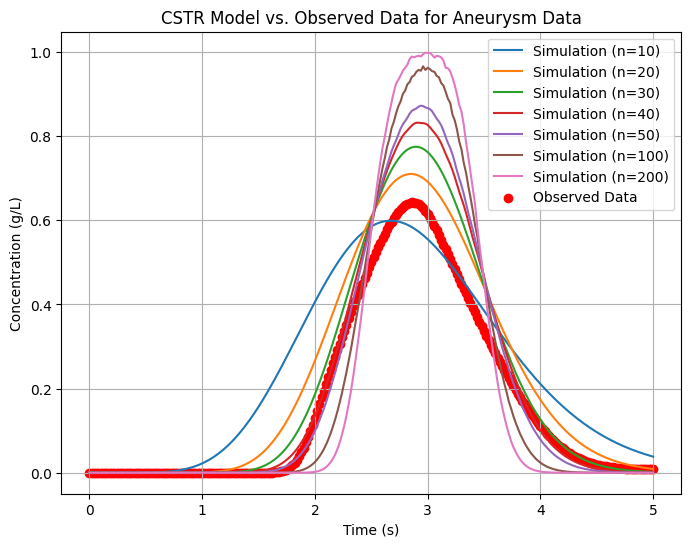

In [12]:
# Manual tuning for n
n_values = [10, 20, 30, 40, 50, 100, 200]

# Plotting for each value of 'n'
plt.figure(figsize=(8, 6))

for n in n_values:
    # Initial conditions for concentration
    C_initial = np.zeros(n)
    C_initial[0] = 1  # Initial concentration in the first tank

    # Solve the ODE system with the given 'n' using the optimal tau from Newton-Raphson
    sol = solve_ivp(cstr_model, [time_aneurysm[0], time_aneurysm[-1]], C_initial, args=(n, optimal_tau_aneurysm, C_inj_function), t_eval=time_aneurysm)

    # calculate the r squared value
    r_squared_value = r_squared(concentration_aneurysm, sol.y[-1])
    print(f'R² for n={n}: {r_squared_value:.4f}')
    
    # Plot the simulation result for the current 'n'
    plt.plot(sol.t, sol.y[-1], label=f'Simulation (n={n})')


plt.scatter(time_aneurysm, concentration_aneurysm, label='Observed Data', color='red')
plt.title('CSTR Model vs. Observed Data for Aneurysm Data')
plt.xlabel('Time (s)')
plt.ylabel('Concentration (g/L)')
plt.legend()
plt.grid()
plt.show()

From the R-squared value, we can see that the 'number of tanks' (from sets of manually picked alternative) values that give the highest R-squared value is 30 with an R-squared value of 0.8981. Hence, we will use $\tau = 2.4837 (s)$ and n = 30 for the aneurysm model.

Part 2

R² for 1s Rectangular Pulse: 0.9375
R² for 2s Rectangular Pulse: 0.9019
R² for 3s Rectangular Pulse: 0.9091
R² for 1s Ramp: 0.8596
R² for Biphasic: 0.8537


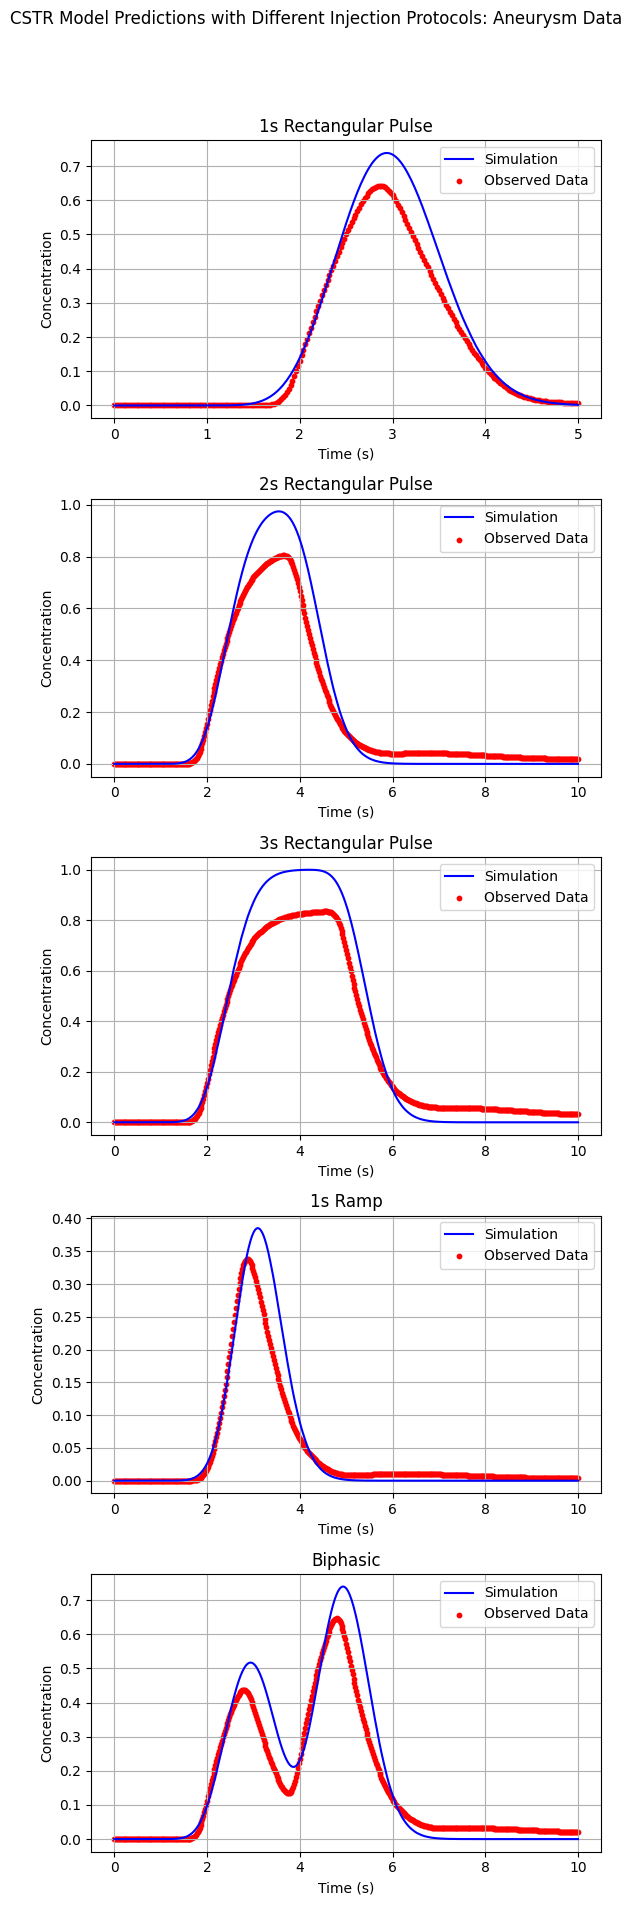

In [13]:
# Parameters
n = 30          # Number of tanks
q = 0.083          # Volumetric flow rate
tau = optimal_tau_aneurysm  # Optimal tau from tuning
C_initial = np.zeros(n)   # Initial concentration in each tank

# Define injection protocols and corresponding data files
injection_protocols = {
    "1s Rectangular Pulse": (lambda t: rectangular(t, 1), 'data/Aneurysm_rect_1s.csv'),
    "2s Rectangular Pulse": (lambda t: rectangular(t,2), 'data/Aneurysm_rect_2s.csv'),
    "3s Rectangular Pulse": (lambda t: rectangular(t, 3), 'data/Aneurysm_rect_3s.csv'),
    "1s Ramp": (lambda t: ramp(t, 1, 1), 'data/Aneurysm_ramp_1s.csv'),
    "Biphasic": (lambda t: biphasic(t), 'data/Aneurysm_biphasic.csv')
}

# Set up subplots
num_protocols = len(injection_protocols)
fig, axs = plt.subplots(num_protocols, 1, figsize=(6, 4 * num_protocols))
fig.suptitle('CSTR Model Predictions with Different Injection Protocols: Aneurysm Data')

for ax, (label, (C_inj_func, data_file)) in zip(axs, injection_protocols.items()):
    # Load the specific dataset for the injection protocol
    data = pd.read_csv(data_file)
    time_data = data['Time'].values
    concentration_data = data['Concentration'].values
    
    # Solve the model with the chosen injection protocol
    sol = solve_ivp(cstr_model, [time_data[0], time_data[-1]], C_initial, 
                    args=(n, tau, C_inj_func), t_eval=time_data)
    
    # Calculate the r squared value
    r_squared_value = r_squared(concentration_data, sol.y[-1])
    print(f'R² for {label}: {r_squared_value:.4f}')
    
    # Plot the model prediction and observed data
    ax.plot(sol.t, sol.y[-1], label='Simulation', color='blue')  # Last tank concentration
    ax.scatter(time_data, concentration_data, label='Observed Data', color='red', s=10)
    ax.set_title(f'{label}')
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Concentration')
    ax.legend()
    ax.grid()

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


Based on the R-squared values and visual inspection of the simulation, and aligned with the result for a healthy case, the model performs slightly better for a rectangular pulse. But overall we can see that the model fits better for the healthy case.

We can also see the different peaks for the aneurysm model compared to the healthy model. In healthy cases, the peak is typically higher and sharper compared to the aneurysm model. This is due to the fact that by a dilation structure in an aneurysm the flow is 'well-mixed' and the tracer is more evenly distributed, resulting in a lower peak concentration.

Part 3  
Compare the number of compartments you ended up with in the two cases (healthy vs. aneurysm). Was it very different, why / why not?  

We ended up with 50 compartments for healthy cases and 30 compartments for aneurysm cases. The difference in the number of compartments reflects the flow dynamic in each case. In the healthy aorta, the flow is typically laminar, characterized by smooth streamlines and a parabolic velocity profile [(Ku, 1999)](#kublood). For modeling, laminar flow can be represented by multiple compartments in a plug flow reactor (PFR) model, which has minimal mixing between compartments which leads to a higher number of compartments. Meanwhile, according to [Valen-sendstad](#valen), the irregular geometry of an aneurysm leads to flow disturbances, indicative of turbulence and mixed. This can be represented with a lower number of compartments which represent systems with significant mixing.

By these findings, it is possible to identify if the aorta arch contains an aneurysm by only observing the tracer signal out of the aorta. The number of compartments can be used as an indicator of the flow dynamics in the aorta, which can be linked to the presence of an aneurysm.

Part 4  
Discuss the strengths and weaknesses of the CSTR approach. What have you learned from this exercise?  
  
The Continuous Stirred-Tank Reactor (CSTR) approach has notable strengths and weaknesses in modeling dynamic systems, particularly in biomedical contexts. Its simplicity and intuitiveness make it an accessible framework for understanding mixing and reaction processes, while its flexibility allows for adaptation to various scenarios by adjusting parameters like the number of compartments and flow rates. The CSTR model facilitates both analytical and numerical solutions, enabling a comprehensive understanding of system behavior. However, it relies on the assumption of perfect mixing, which may not reflect the realities of biological systems, potentially leading to inaccuracies in concentration predictions. Additionally, the model's spatial resolution is limited by compartment discretization, and it can be sensitive to parameter choices, requiring careful calibration. The computational complexity increases with the number of compartments, presenting challenges in simulation time and resource demands. Through this exercise of modeling tracer behavior in healthy versus aneurysmal cases, key insights emerged regarding the importance of parameter tuning, the physiological implications of flow dynamics, and the need to balance model complexity with accuracy. Utilizing optimization techniques like the Newton-Raphson method highlighted the value of mathematical approaches in refining models. Overall, while the CSTR approach serves as a valuable tool in understanding tracer dynamics, it underscores the importance of considering its assumptions and limitations in the context of complex biological systems.

**Exercise 4 (OPTIONAL): Extend model**  
Part 1

We modified our former CSTR model function to include diffusive exchange with the aneurysm. From what we understand, the modification is done by changing the equation for the flow rate by introducing new parameters $D$ and $V_A$. D acts as an effective diffusion constant, while $V_A$ is the volume of the aneurysm. The new equation for the flow rate is given by:
$$V \cdot \frac{dC_i}{dt} = q \cdot (C_{i-1} - C_i) - D \cdot (C_i - C_A)$$
$$V_A \cdot \frac{dC_A}{dt} = D \cdot (C_i - C_A)$$

We should put the new equation at a specific position towards the outlet, in this case, we put it at the end of the aorta. Our CSTR model consists of $n+1$ compartments, where the last compartment represents the aneurysm. 

In [14]:
# Define an extended CSTR model with diffusion
def cstr_model_extended(t, C, n, tau, q, VA, D, C_inj_function):
    '''Extended CSTR model with diffusiion
    params:
    t: time (s)
    C: concentration (g/L)
    n: number of compartments (excluding aneurysm)
    tau: Vtot/q (s)
    q: flow rate (L/s)
    VA: volume of the aneurysm compartment (L)
    D: effective diffusion rate between aorta and aneurysm (L/s)
    C_inj_function: input concentration function
    Return:
    dCdt: Rate of change of concentration for each tank and aneurysm compartment
    '''
    #initialize dCdt array
    dCdt = np.zeros(n+1) # Create n compartments plus 1 compartment for aneurysm
    C_inj = C_inj_function(t)
    dCdt[0] = (n/tau) * (C_inj - C[0]) - D * (C[0] - C[-1]) / q
    for i in range(1, n):
        dCdt[i] = (n/tau) * (C[i-1] - C[i]) - D * (C[i] - C[-1]) / q

    # Aneurysm compartment at the end
    dCdt[-1] = D * (C[-2] - C[-1]) / VA

    return dCdt


Upon doing this, we find that using $D = 10 * q$ as an initial guess for the diffusion constant does not work well for our model. We guess that because the value is too high it leads to rapid mixing between the compartments, which results in a very low peak concentration.
Hence, we decided to use $D = 0.1 * q$ as the diffusion constant, which gives a better result.

R² for n=30: 0.9947


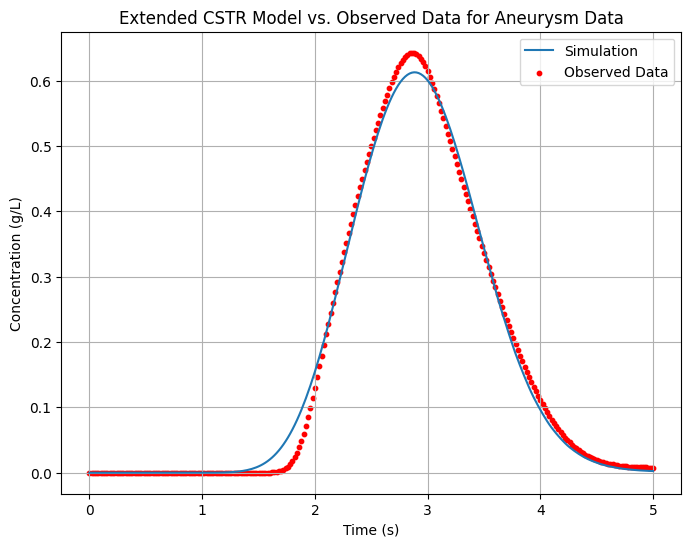

In [15]:
# Load data from CSV
data_aneurysm = pd.read_csv('data/Aneurysm_rect_1s.csv') 
time_aneurysm = data_aneurysm['Time'].values
concentration_aneurysm = data_aneurysm['Concentration'].values

# Parameters
n = 30  # using optimal n value for aneurysm data
q = 0.083  # Volumetric flow rate (L/s)
tau = optimal_tau_aneurysm #using optimal tau value (s)
VA = 1 #initial guess of aneurysm compartment volume (L)
D = 0.1 * q #initial guess of effective diffusion rate (L/s)
C_inj_function = lambda t: rectangular(t, 1)  # Rectangular pulse at t=1

C_initial = np.zeros(n+1) 
C_initial[0] = 1 

sol = solve_ivp(cstr_model_extended, [time_aneurysm[0], time_aneurysm[-1]], C_initial, 
                args=(n, tau, q, VA, D, C_inj_function), t_eval=time_aneurysm)

# calculate the r squared value
r_squared_value = r_squared(concentration_aneurysm, sol.y[-2])
print(f'R² for n={n}: {r_squared_value:.4f}')

# Plot the simulation result
plt.figure(figsize=(8, 6))
plt.plot(sol.t, sol.y[-2], label='Simulation')
plt.scatter(time_aneurysm, concentration_aneurysm, label='Observed Data', color='red', s=10)
plt.title('Extended CSTR Model vs. Observed Data for Aneurysm Data')
plt.xlabel('Time (s)')
plt.ylabel('Concentration (g/L)')
plt.legend()
plt.grid()
plt.show()


Using the initial value of $V_A = 1$ and $D=0.1*q$, we found that the simulation result fits the experimental data better than the previous model (without diffusive exchange). The R-squared value for the model with diffusive exchange is 0.9947 which is higher than 0.94 for the model without diffusive exchange. This indicates that the model with diffusive exchange provides a better representation of the tracer dynamics in the aorta with an aneurysm.

In [16]:
# Objective function to minimize (SSR)
def objective_function_extended(params, n, q, time_data, concentrations_data, C_inj_function):
    VA, D = params
    C_initial = np.zeros(n+1)
    C_initial[0] = 1  # Initial concentration in the first tank

    # Solve the ODEs
    sol = solve_ivp(cstr_model_extended, [time_data[0], time_data[-1]], C_initial, 
                    args=(n, tau, q, VA, D, C_inj_function), t_eval=time_data)
    
    # Compute simulated effluent concentration
    simulated_concentration = sol.y[-2]  # Last tank concentration

    # Calculate SSR
    ssr = np.sum((simulated_concentration - concentrations_data)**2)
    return ssr

# Alternative optimization using scipy.optimize.minimize
from scipy.optimize import minimize

# Initial guess for VA and D
initial_guess = [1, 0.1*q]

# bounds for VA and D
bounds = [(0.01, 10), (0.01 * q, 10*q )]

n= 30
q = 0.083
tau = optimal_tau_aneurysm
C_inj_function = lambda t: rectangular(t, 1)

# Use scipy.optimize.minimize with BFGS
result = minimize(objective_function_extended, x0=initial_guess, args=(n, q, time_aneurysm, concentration_aneurysm, C_inj_function), bounds=bounds)
optimal_params = result.x
print(f"Optimal VA: {optimal_params[0]:.4f} (L)")
print(f"Optimal D: {optimal_params[1]:.4f} (L/s)")



Optimal VA: 0.9999 (L)
Optimal D: 0.0078 (L/s)


R² for n=30: 0.9951


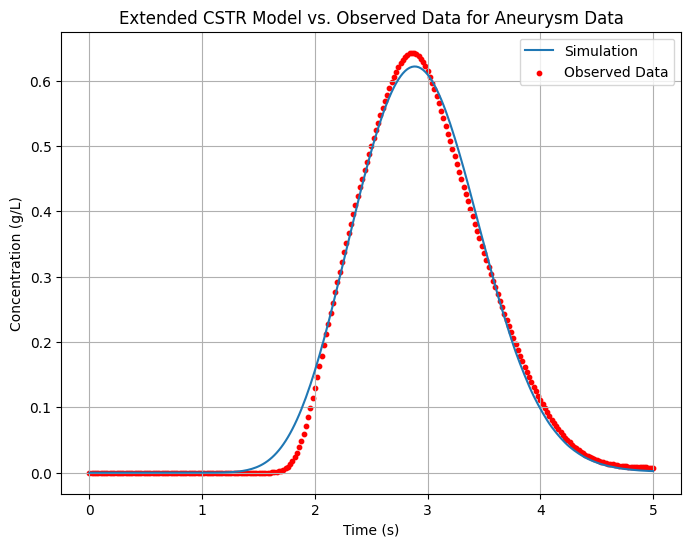

In [17]:
#using optimal VA and D values
VA = optimal_params[0]
D = optimal_params[1]

sol = solve_ivp(cstr_model_extended, [time_aneurysm[0], time_aneurysm[-1]], C_initial,
                args=(n, tau, q, VA, D, C_inj_function), t_eval=time_aneurysm)

# calculate the r squared value
r_squared_value = r_squared(concentration_aneurysm, sol.y[-2])
print(f'R² for n={n}: {r_squared_value:.4f}')

# Plot the simulation result
plt.figure(figsize=(8, 6))
plt.plot(sol.t, sol.y[-2], label='Simulation')
plt.scatter(time_aneurysm, concentration_aneurysm, label='Observed Data', color='red', s=10)
plt.title('Extended CSTR Model vs. Observed Data for Aneurysm Data')
plt.xlabel('Time (s)')
plt.ylabel('Concentration (g/L)')
plt.legend()
plt.grid()
plt.show()


Upon doing the optimization of VA and D by minimizing the SSR value, using the build-in minimize function from Scipy.optimize, we found that the optimal value for VA is 0.9999 and D is 0.0078. This value gives the highest R-squared value of 0.9951, slightly higher than our base model.

# Summary  
First, we developed an ODE solver to approximate tracer dynamics in an aorta-like system using Euler, RK2, and RK4 methods, comparing their accuracy against analytical solutions. This analysis revealed the trade-offs between computational efficiency and accuracy. Overall, we learned that simpler computational methods usually have bigger errors, but not always, because they can also be influenced by starting conditions, for example.  
   
The next exercise challenges us to recreate and validate the CSTR model across various injection protocols using Python, tuning model parameters like $\tau$ and the number of compartments (n) for optimal data alignment. Through the Newton-Rahpson method, we achieve the best match for healthy aorta data. Following this, we predict outcomes for other injection protocols using the same model setup and analyze model accuracy by comparing predictions to CFD data. This exercise not only explores the potential of tracer signals in aortic diagnostics but also evaluates the robustness of the CSTR model for varying injection profiles.  

The last mandatory exercise builds on the previous analysis by applying the CSTR model to the aneurysmal aorta data, requiring recalibration of $n$ and $\tau$ to match CFD outputs. Here, we encountered limitations of the Newton-Raphson method, particularly its sensitivity to initial guesses. By comparing compartment counts between healthy and aneurysmal cases, we assessed whether aneurysms significantly altered model requirements. Finally, we discuss the strengths and limitations of the CSTR approach, reflecting on the insights gained from modeling tracer dynamics in healthy and unhealthy aortas, as well as the diagnostic potential and challenges of this methodology.

In an extended version of the CSTR model, we incorporated diffusive exchange to better match data for an aorta with an aneurysm. The addition of diffusive exchange provided a more accurate representation of tracer dynamics in aneurysmal aortas, demonstrating the value of enhancing simplified models with additional physical processes to improve predictive capabilities and deepen our understanding of biological systems.

For future assignments, improvements could include strengthening the validation process of the model by using R-squared values or other relevant metrics. Additionally, it would be helpful if the project guidelines offered more detailed explanations of the extended model.

# References
1. <div id="hiorth"></div> A. Hiorth.  Computational Engineering and Modeling, https://github.com/ahiorth/CompEngineering, 2021. 
2. <div id="kublood"></div>Ku, D. N. (1997), "Blood flow in arteries." Annual Review of Fluid Mechanics, 29(1), 399-434. https://doi.org/10.1146/annurev.fluid.29.1.399
3. <div id="deuflhand"></div>Deuflhard, P. (2011). Newton Methods for Nonlinear Problems: Affine Invariance and Adaptive Algorithms (1st ed., Vol. 35). Springer Nature. https://doi.org/10.1007/978-3-642-23899-4
4. <div id="valen"></div>Valen-Sendstad, K., Piccinelli, M., & Steinman, D. A. (2014). High-resolution computational fluid dynamics detects flow instabilities in the carotid siphon: Implications for aneurysm initiation and rupture? Journal of Biomechanics, 47(12), 3210–3216. https://doi.org/10.1016/j.jbiomech.2014.04.018
5. <div id="wu"></div>Wu, H., Xue, H., & Kumar, A. (2012). Numerical Discretization‐Based Estimation Methods for Ordinary Differential Equation Models via Penalized Spline Smoothing with Applications in Biomedical Research. Biometrics, 68(2), 344–352. https://doi.org/10.1111/j.1541-0420.2012.01752.x